In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [65]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [19]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [20]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [31]:
# Getting table columns
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
print("\033[1m"+"Measurement Columns"+"\033[0m")
for c in columns:
    print(c['name'], c["type"])
print("--")
print("\033[1m"+"Station Columns"+"\033[0m")
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

Measurement Columns
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--
Station Columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [90]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23')

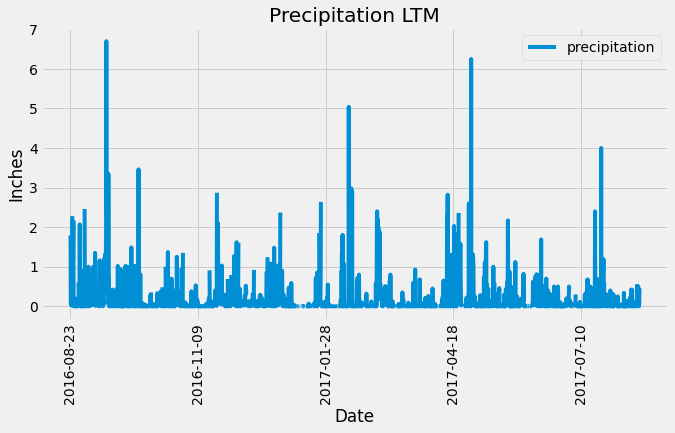

In [113]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017,8,23) - relativedelta(months=12)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_rows = [{"Date":p[0], "precipitation":p[1]} for p in precipitation]
precipitation_df = pd.DataFrame(prcp_rows).set_index("Date")

# Sort the dataframe by date
precipitation_df.sort_values("Date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(kind="line", figsize=(10,5), rot="vertical")
plt.title("Precipitation LTM")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()


In [115]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [120]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.id).count()
print("Total number of stations: "+str(total_stations)+".")

Total number of stations: 9.


In [146]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [170]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_activity[0][0]
lowest_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.tobs.asc()).first()
highest_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.tobs.desc()).first()
total_temp = session.query(func.sum(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).one()
most_active_station_count = station_activity[0][1]
average_temp = total_temp[0]/most_active_station_count
print("\033[1m"+"Temperatures for Station "+most_active_station+"\033[0m")
print(f'Lowest: {lowest_temp[0]}.')
print(f'Highest: {highest_temp[0]}.')
print(f'Average: {round(average_temp,1)}.')

Temperatures for Station USC00519281
Lowest: 54.0.
Highest: 85.0.
Average: 71.7.


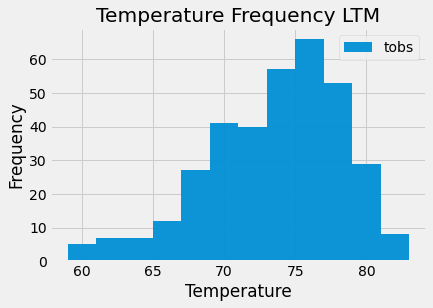

In [183]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the data and precipitation scores
temperature = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= one_year_ago).\
    filter(Measurement.station == most_active_station).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_rows = [{"Date":t[0], "tobs":t[1]} for t in temperature]
temperature_df = pd.DataFrame(temp_rows).set_index("Date")

# Sort the dataframe by date
temperature_df.sort_values("tobs", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
temperature_df.plot(kind='hist', bins=12, alpha=.95)
plt.title("Temperature Frequency LTM")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()



# Close session

In [184]:
# Close Session
session.close()